In [27]:
#%matplotlib notebook
%matplotlib inline
#Module to handle regular expressions
import re
#Library for emoji
import emoji
#Import pandas and numpy to handle data
import pandas as pd
import numpy as np

#import libraries for accessing the database
import psycopg2
from sqlalchemy import create_engine
from postgres_credentials import *

#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Import nltk to check english lexicon
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

#import libraries for tokenization and ML
import json;
import keras;
import keras.preprocessing.text as kpt;
from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.feature_extraction.text import CountVectorizer

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from keras.models import Sequential;
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from keras.layers import Dense, Dropout, Activation;

In [2]:
#Querying the database
def query_database(tabletweets):
    engine = create_engine("postgresql+psycopg2://%s:%s@%s:%d/%s" %(usertwitter, passwordtwitter, hosttwitter, porttwitter, dbnametwitter))
    table = pd.read_sql_query('select * from %s' %tabletweets,con=engine, index_col='id')
    return table

In [3]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['tweet'] = table['tweet'].str.lower()
    #Replace rt indicating that was a retweet
    table['tweet'] = table['tweet'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['tweet'] = table['tweet'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['tweet'] = table['tweet'].replace(r'http\S+', '', regex=True)
    table['tweet'] = table['tweet'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['tweet'] = table['tweet'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['tweet'] = table['tweet'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return table    

In [4]:
#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row 

In [11]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['tweet'] = table['tweet'].str.lower()
    table['tweet'] = table['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [6]:
def handling_negation(row):  

SyntaxError: unexpected EOF while parsing (<ipython-input-6-923e8aa17935>, line 1)

In [ ]:
def replace_contractions():

In [ ]:
def stemming_tweets():

In [12]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['tweet'] = table['tweet'].apply(lambda x: detect_elongated_words(x))
    table = stop_words(table)
    #table = handling_negation()
    #table = replace_contractions()
    #table = stemming_tweets()
    return table

In [7]:
#Processing the data: Tokenization
def tokenization_tweets(table):
    tokenization = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
    tokenization.fit_on_texts(table['tweet'])
    return tokenization

In [29]:
#Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.tweet)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [33]:
a = vectorization(tweet_table)

In [36]:
a.sort_values(0, ascending=False)

,0
avengers,145028
endgame,40964
spiderman,37599
marvel,35480
movies,26668
movie,26241
infinity,23350
war,22338
lion,19644
story,19067


In [5]:
#Create a Neural Network
#Create the model
def train():
    model_nn = Sequential()
    model.add(Dense(512, input_shape=(max_words,), activation='relu'))
    model.add(Dropout(0.5))
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acuracy'])
    model.fit(X_train, Y_train,
             batch_size=32,
             epochs=5,
             verbose=1,
             validation_split=0.1,
             shuffle=True)
    pred=model.predict(input_data)
    labels[np.argmax(pred)], pred[0][np.argmax(pred)]

In [13]:
if __name__ == "__main__":
    tabletweets = 'tweets_avengers'
    tweet_table = query_database(tabletweets)
    tweet_table = cleaning_table(tweet_table) 

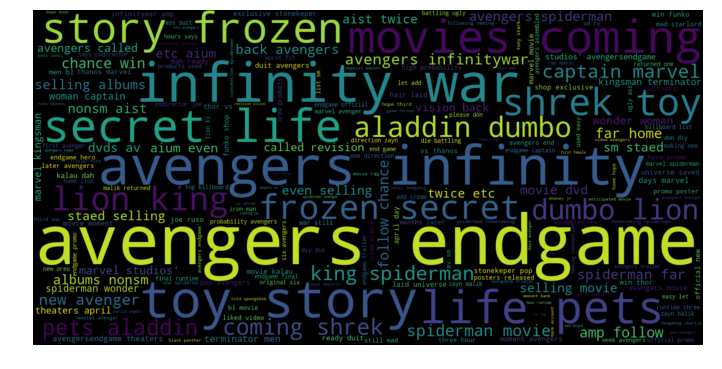

In [22]:
from wordcloud import WordCloud



foranalysis = tweet_table
a_string = []
for t in foranalysis.tweet:
    a_string.append(t)
a_string = pd.Series(a_string).str.cat(sep=' ')



wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(a_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
